# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Behavior" data-toc-modified-id="Behavior-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Behavior</a></div><div class="lev1 toc-item"><a href="#Pre-epoching" data-toc-modified-id="Pre-epoching-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-epoching</a></div>

In [3]:
import os
os.chdir('../../')

In [4]:
from spikelearn.data import io
import pandas as pd
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import h5py

In [3]:
animal = 'r4'

In [4]:
f = h5py.File('data/raw/%s/day1/Behavior.mat'%animal, 'r')

OSError: Unable to open file (unable to open file: name = 'data/raw/r4/day1/Behavior.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
spikes = loadmat('data/raw/%s/day1/spikes/openephys.spikes.cellinfo.mat'%animal)['spikes'][0,0]

In [ ]:
pd.DataFrame(spikes[4])

In [ ]:
waveforms = pd.DataFrame(np.stack(spikes[4].squeeze()).squeeze(), index=pd.Index(np.hstack(spikes[6].squeeze()), name='area'))

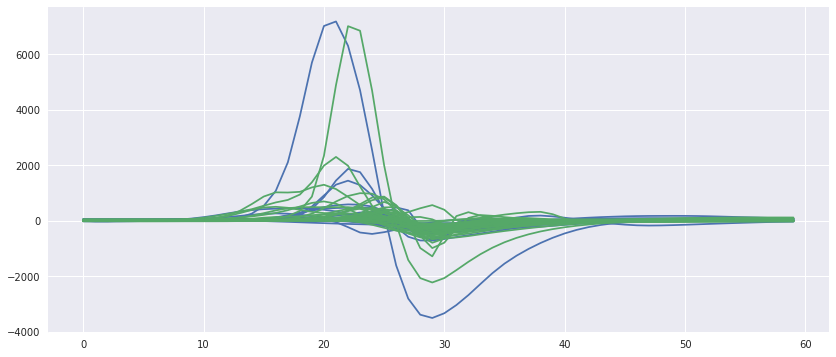

In [155]:
fig, ax = plt.subplots(1,1, figsize=(14,6))
pd.DataFrame(waveforms.loc['PFC']).transpose().plot(color='b',ax=ax, legend=False)
pd.DataFrame(waveforms.loc['STR']).transpose().plot(color='g',ax=ax, legend=False)

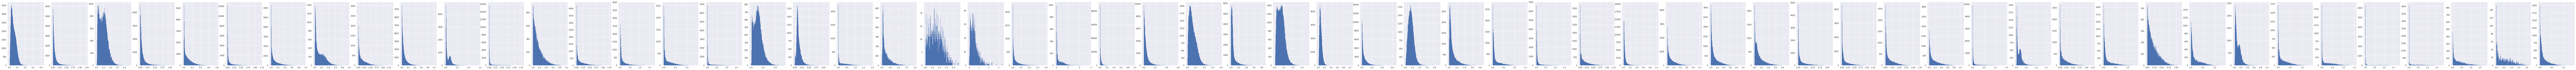

In [436]:
n_units = len(spikes[1].ravel())

plt.figure(figsize=(4*n_units,6))
for i in range(n_units):
    plt.subplot(1,n_units,i+1)
    plt.hist(np.log10(np.diff(spikes[1].squeeze()[i].reshape(-1))), 200);

---

# Behavior 

In [8]:
def behav_to_df(hdFile):
    behav = pd.DataFrame({'duration':f['behavior']['DRRD'][:].reshape(-1),
    'offset':f['behavior']['NPEnd'][:].reshape(-1),
    'onset':f['behavior']['NPStart'][:].reshape(-1)}, index=pd.Index(np.arange(f['behavior']['DRRD'].shape[1])+1, name='trial'))

    assert not any(behav.duration != (behav.offset - behav.onset)), 'There are inconsistencies in duration'
    return behav

In [9]:
behavior = behav_to_df(f)
behavior.head()

,duration,offset,onset
trial,,,
1,0.157967,3735.380067,3735.222100
2,1.462133,3736.842233,3735.380100
3,1.307200,3739.519400,3738.212200
4,0.924133,3742.260167,3741.336033
5,1.681867,3775.971967,3774.290100


---

# Pre-epoching

We want the data in the following format, so that it will enter the pipeline in early stages

In [5]:
import pandas as pd
from itertools import product

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from spikelearn.models import shuffle_val_predict
from spikelearn.data import io, SHORTCUTS, to_feature_array, select

from sklearn.metrics import confusion_matrix
# For decoding
tmin = 1.5;
tmax = 10;
DSETS = ['medium_smoothed', 'medium_smoothed_norm']
CLFs = [LogisticRegression, GaussianNB]

ntrials_init_vs_after = 50



In [7]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
mm= MinMaxScaler()
clf = Pipeline([('mm', mm), ('clf', LogisticRegression())])

In [54]:
data = io.load('ELI 4', 'wide_smoothed')

In [35]:
data = select(data, _min_duration=tmin, _max_duration=tmax, _mineq_quality=1)

dataPFC = select(data, area='PFC')
dataSTR = select(data, area='STR')

trials = data.reset_index().trial.unique()

#sep = trials[ntrials_init_vs_after]

In [18]:
data

full  \
trial unit                                                      
8     0     [0.634949961066, 0.999127676647, 0.93650355429...   
      1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011...   
      2     [0.0, 0.0, 0.00870670030881, 0.0819619587596, ...   
      3     [0.0, 0.0, 0.0, 0.0, 0.00198287936641, 0.03960...   
      4     [0.0824751982497, 0.271850118174, 0.4977878226...   
      6     [3.21228804466, 3.64124268137, 3.75687885845, ...   
      7     [0.0550497280331, 0.279741800744, 0.6784781051...   
      8     [5.2828466436e-05, 0.0227443450228, 0.13668111...   
      9     [0.00813100180586, 0.073153147257, 0.258580673...   
      10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      12    [1.78494121753, 1.20632711713, 0.942240789048,...   
      13    [2.14887446267, 1.72418754252, 1.22143680693, ...   
      14    [0.360191362201, 0.615089170496, 0.64896391232...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0180466444253...   
15    0     [0.00040846771607, 0.0260883272771, 0.15320996...   
      1     [1.11520269237, 0.827651331433, 0.700491775871...   
      2     [1.12990325923, 1.1419972443, 1.55506290669, 1...   
      3     [0.0158976768819, 0.104289937932, 0.3033677320...   
      4     [0.0, 0.0, 0.00632618202125, 0.0689398153948, ...   
      6     [2.00317037301, 1.48805373934, 0.890802632606,...   
      7     [3.23771966064, 2.05651421953, 0.905720420372,...   
      8     [0.00610079995145, 0.0632281144817, 0.24074162...   
      9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...   
      10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      12    [0.172932035592, 0.375216730639, 0.53144650738...   
      13    [1.06329083649, 1.06682103479, 1.31593315071, ...   
      14    [1.11479071111, 1.28716469333, 1.24597873408, ...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
23    0     [1.13128645809, 1.68825050396, 1.46290039995, ...   
      1     [0.0, 0.00260211480968, 0.0481886171065, 0.259...   
...                                                       ...   
533   14    [1.632063091, 0.854505177975, 0.253214433984, ...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
535   0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0076611030208...   
      1     [0.0589381490301, 0.28519418108, 0.67068676172...   
      2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      4     [0.0, 0.0, 0.00288014150799, 0.0465132233111, ...   
      6     [0.553328110899, 0.466811382853, 0.50163412835...   
      7     [1.36191722718, 1.03935558224, 0.53553205167, ...   
      8     [0.816571213685, 0.660907345924, 0.38001933401...   
      9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      10    [0.0, 0.0, 0.00188836466921, 0.0388057795651, ...   
      12    [1.50001542979, 1.82797005468, 1.35325902799, ...   
      13    [1.67148834852, 0.967553310046, 0.57102278955,...   
      14    [0.249468616532, 0.396254201943, 0.31004254066...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
538   0     [0.467133461154, 0.671872138954, 0.60754850531...   
      1     [0.0, 0.000404427478712, 0.0253788659393, 0.16...   
      2     [1.696184137, 0.643309132466, 0.123565288665, ...   
      3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      4     [0.530570860331, 0.584207947647, 0.69796612597...   
      6     [7.825693463, 7.66416439865, 6.73752668739, 4....   
      7     [0.137065655992, 0.323606863475, 0.37324189631...   
      8     [0.0682777713363, 0.348532320629, 0.8876591377...   
      9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      12    [0.0, 0.0, 0.0, 0.0, 0.00143048072219, 0.03676...   
      13    [0.681348157965, 0.49445755731, 0.394039828972...   
      14    [1.4051371682, 1.0000106472, 0.566559091711, 0...   
      15    [0.0, 0.0, 0.0,

In [46]:
res = shuffle_val_predict(clf, to_feature_array(data), n_splits=100, get_weights=False)
#resPFC = shuffle_val_predict(XGBClassifier(), to_feature_array(dataPFC), n_splits=30)
#resSTR = shuffle_val_predict(LogisticRegression(C=1), to_feature_array(dataSTR), n_splits=30)

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


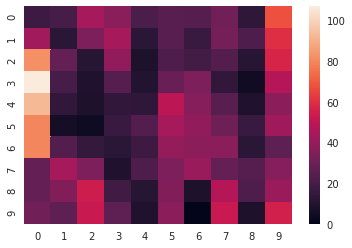

In [47]:
sns.heatmap( confusion_matrix(res.predictions.true_label,res.predictions.predictions_max))

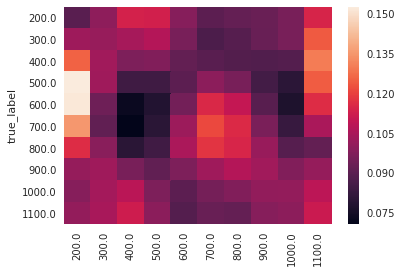

In [48]:
sns.heatmap(res.proba.groupby('true_label').mean().drop('group',axis=1))

In [52]:
res.score.mean()

score_max    -0.015384
score_mean    0.021930
dtype: float64

In [41]:
a=data.full.reset_index().groupby('unit').apply(lambda x: [np.vstack(x.full.apply(lambda x: x[:15])).mean(axis=0)])

---